In [ ]:

import yfinance as yf
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import random

import plotly
import cufflinks
plotly.__version__
from datetime import datetime, timedelta

## helper functions

"""
This grabs the start date given the end date and how
many days back you want to go
Input: string, int
Return: string
"""
def date_before_x_days(end_date, days_back):
  start_date = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=days_back)
  return start_date.strftime('%Y-%m-%d')


"""
This deletes any stocks that doesn't have data from
our data set. Updates stocks left, data set, and the
stock count.
Input: list<string>, dataframe, int
Return: list<string>, dataframe, int
"""
def clean_data(stocks, dataset, stock_count):
  no_vals = []  ## stocks that don't have data
  for stock in stocks:
    d = dataset["Close"][stock].to_list()
    if any(np.isnan(i) for i in d):
      no_vals.append(stock)

  stock_count -= len(no_vals)  ## eliminating empty stock from count

  for stock in no_vals:
    stocks.remove(stock)  ## eliminating empty stock from STOCKS
    dataset = dataset.drop(columns=stock, level = 1)  ## dropping these stocks from our data

  return stocks, dataset, stock_count


"""
Given a dataset, we construct a dictionary representation
of our feature matrix to ensure the features are in the
same column. They are also labeled for simplicity
Outmost key is stock name
Inner key is feature name
Input: list<string>, dataframe, int
Return: dict<string, dict<string, int>>
"""
def make_feature_dict(stocks, dataset, window):
  X = {stock : {"const" : 1} for stock in stocks}  ## this will be our data

  ## Adj Close, Close, High, Low, Open, Volume (added here) (these are for a single day)
  for stock in stocks:
    X[stock]["Adj Close"] = dataset["Adj Close"][stock][-1]
    X[stock]["Close"] = dataset["Close"][stock][-1]
    X[stock]["High"] = dataset["High"][stock][-1]
    X[stock]["Low"] = dataset["Low"][stock][-1]
    X[stock]["Open"] = dataset["Open"][stock][-1]
    X[stock]["Volume"] = dataset["Volume"][stock][-1]

  ## SMA, Volatility, EMA, RSI (over last WINDOW_SIZE days) (these are more long-term information)
  for stock in stocks:
    g = dataset["Adj Close"][stock]  ## I used Adjusted Close for stability

    X[stock]["SMA"] = g.rolling(window=window).mean().iloc[-1]
    f = np.log(g / g.shift(1))
    X[stock]["Volatility"] = np.std(f[-window:])  ## this is how you calculate volatility
    X[stock]["EMA"] = g.ewm(span=window, adjust=False).mean().iloc[-1]

    delta = g.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    X[stock]["RSI"] = rsi.iloc[-1]
  return X


"""
Turns the Feature Matrix in Dictionary Form into an actual numpy matrix
"""
def dict_to_matrix(X):
  X_matrix = []
  for stock, features in X.items():
    temp = []

    for name, feature in features.items():
      temp.append(feature)

    X_matrix.append(temp)

  return np.array(X_matrix)


"""
Obtains the Y vector for the given stocks on the end_date
Input: string, int, list<string>
Return: list<int>
"""
def obtain_y(end_date, stocks, days_back=7):
  start_date = date_before_x_days(end_date, days_back)
  y_data = yf.download(stocks, start=start_date, end=end_date)["Adj Close"].iloc[-1]
  return np.array([y_data[stock] for stock in stocks])

In [ ]:
# 3/19/24: Here, I am plotting the efficient frontier.
from sklearn.model_selection import train_test_split
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_data = pd.read_html(URL)[0]

ALL_STOCKS = sp500_data['Symbol'].to_list()  ## grab random sample of this??
# First, I want to generate many different portfolios. Let's say we create 10 to start
num_portfolios = 10
portfolios = []

# First method: Loop to create portfolios
for i in range(num_portfolios):
    start = i * 50
    num_stocks = (i + 1) * 50
    portfolio_stocks = ALL_STOCKS[start:num_stocks]
    portfolios.append(portfolio_stocks)
print(len(portfolios))

# Second method
ALL_STOCKS = ALL_STOCKS[:100]
for i in range(num_portfolios):
    portfolios.append(random.sample(ALL_STOCKS, 50)) # Second method
print(len(portfolios))

10


In [ ]:
# Helper functions
###############################################################################
import numpy as np
from scipy.optimize import minimize

GO_BACK = 50  ## DATA USED FOR ML

# Step 1: RIDGE REGRESSION
def ridge_obtain_thetas(training_X, training_y, lmbda = 2, iterations = 10000000, eps = 1e-3, alpha = 1e-5):
    cur_weights = np.zeros(training_X.shape[1])
    for _ in range(iterations):
      old_weights = cur_weights
      cur_weights = old_weights - alpha * (training_X.T.dot(training_X.dot(old_weights) - training_y) + lmbda * old_weights)
      if np.linalg.norm(cur_weights - old_weights) < eps:
        break
      else:
        print("increase iterations")

      theta = cur_weights
      return theta

# Step 2: HISTORICAL MATRIX STUFF
def generate_daily_return_vec(closing_prices_vec):
  daily_returns_vec = []
  for i in range(1, len(closing_prices_vec)):
    daily_return = ((closing_prices_vec[i] - closing_prices_vec[i-1]) / closing_prices_vec[i-1]) * 100
    daily_returns_vec.append(daily_return)
  return daily_returns_vec

# Helper function to calculate the covariance between two assets
def calculate_covariance_hist(asset1, asset2):
  closing_prices_asset1 = testing_data["Adj Close"][asset1][-GO_BACK:]
  closing_prices_asset2 = testing_data["Adj Close"][asset2][-GO_BACK:]
  daily_returns_asset1, daily_returns_asset2 = generate_daily_return_vec(closing_prices_asset1), generate_daily_return_vec(closing_prices_asset2)
  sample_means_1, sample_means_2 = np.mean(daily_returns_asset1), np.mean(daily_returns_asset2)
  # Subtract the sample means from each element of the respective daily returns vectors
  deviation_1, deviation_2 = daily_returns_asset1 - sample_means_1, daily_returns_asset2 - sample_means_2
  # Next step
  un_normalized_covariance = np.sum(deviation_1 * deviation_2) # element-wise multiplication
  covariance = (1 / (GO_BACK - 1)) * un_normalized_covariance # Check that N - 1 is correct
  return covariance

# Function to calculate covariance matrix given a vector of stocks
def calculate_covariance_matrix_hist(stocks): #param: vector of stocks
  num_stocks = len(stocks)
  covariance_matrix = np.zeros((num_stocks, num_stocks))
  for i in range(num_stocks):
    asset1 = stocks[i]
    for j in range(num_stocks):
      asset2 = stocks[j]
      covariance_matrix[i, j] = calculate_covariance_hist(asset1, asset2)
  return covariance_matrix

# Simple model
def calculate_markowitz_weights_simple(sigma_squared, expected_returns, covariance_matrix):

  def objective(weights, expected_returns):
    return -np.dot(weights, expected_returns)

  # Weights must be between 0 and 1
  bounds = tuple((0, 1) for _ in range(len(expected_returns)))

  # Initial guess for weights
  initial_guess = np.ones(len(expected_returns)) / len(expected_returns) # [1/5, 1/5, etc.]

  constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

  result = minimize(objective, initial_guess, args=(expected_returns,), method='SLSQP', bounds=bounds, constraints=constraint)
  optimal_weights_complex = result.x
  return optimal_weights_complex

# Step 3: Complex (2-constraint) Markowitz model
def calculate_markowitz_weights_complex(sigma_squared, expected_returns, covariance_matrix):

  def objective(weights, expected_returns):
    return -np.dot(weights, expected_returns)

  # Set bounds for individual weights (0 <= weight <= 1)
  bounds = tuple((0, 1) for _ in range(len(expected_returns)))

  # Initial guess for weights
  initial_guess = np.ones(len(expected_returns)) / len(expected_returns) # [1/5, 1/5, etc.]

  # Constraints
  constraint_1 = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
  constraint_2 = {'type': 'ineq', 'fun': lambda weights: sigma_squared - np.dot(weights.T, np.dot(covariance_matrix, weights))}
  constraints = [constraint_1, constraint_2]

  result = minimize(objective, initial_guess, args=(expected_returns,), method='SLSQP', bounds=bounds, constraints=constraints)
  optimal_weights_complex = result.x
  return optimal_weights_complex

# FOR A GIVEN LEVEL OF RISK (has to EQUAL sigma_squared)
def calculate_markowitz_weights_efficient(sigma_squared, expected_returns, covariance_matrix):

  def objective(weights, expected_returns):
    return -np.dot(weights, expected_returns)

  # Set bounds for individual weights (0 <= weight <= 1)
  bounds = tuple((0, 1) for _ in range(len(expected_returns)))

  # Initial guess for weights
  initial_guess = np.ones(len(expected_returns)) / len(expected_returns) # [1/5, 1/5, etc.]

  # Constraints
  constraint_1 = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
  constraint_2 = {'type': 'eq', 'fun': lambda weights: sigma_squared - np.dot(weights.T, np.dot(covariance_matrix, weights))}
  constraints = [constraint_1, constraint_2]

  result = minimize(objective, initial_guess, args=(expected_returns,), method='SLSQP', bounds=bounds, constraints=constraints)
  optimal_weights_complex = result.x
  return optimal_weights_complex

# Step 4: Getting portfolio returns
def get_actual_returns(TESTING_STOCKS):
  actual_returns_testing = []
  for i in range(len(TESTING_STOCKS)):
    stock = TESTING_STOCKS[i]
    # Grab beginning value (Dec 28 2018)
    beginning_val = testing_data["Adj Close"][stock]["2018-12-28"] # END_DATE
    ending_val = testing_y[i]
    ret = ((ending_val - beginning_val) / beginning_val) * 100
    actual_returns_testing.append(ret)
  return actual_returns_testing

def calculate_portfolio_return(weight_vec):
  actual_returns = get_actual_returns(TESTING_STOCKS)
  portfolio_return = weight_vec.dot(actual_returns)
  return portfolio_return

# Step 5: Getting portfolio risk
def calculate_portfolio_risk(weights, covariance_matrix):
    # Calculate portfolio variance
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))

    # Calculate portfolio standard deviation (risk)
    portfolio_risk = np.sqrt(portfolio_variance)

    return portfolio_risk

# Step 5 alternative: getting portfolio variance
def calculate_portfolio_variance(weights, covariance_matrix):
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    return portfolio_variance

[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['ABNB', 'ANET']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABNB']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
[*********************100%%**********************]  46 of 46 completed
[*********************100%%**********************]  46 of 46 completed


increase iterations


[                       0%%                      ]

0.7796336387560243


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2012-08-16 -> 2013-12-31)')
ERROR:yfinance:['CZR', 'CARR', 'CTLT']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2017-08-16 -> 2018-12-31)')
ERROR:yfinance:['CARR']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  44 of 44 completed
[*********************100%%***************

increase iterations
0.8185874077831157


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['CFG', 'CEG', 'DAY', 'CTVA']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['CEG', 'CTVA']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
[*********************100%%**********************]  45 of 45 completed
[*********************100%%**********************]  45 of 45 completed


increase iterations


[                       0%%                      ]

0.9074023232564029


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['DOW', 'ETSY']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
[*********************100%%**********************]  48 of 48 completed
[*********************100%%**********************]  48 of 48 completed


increase iterations


[                       0%%                      ]

0.827543606981275


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
6 Failed downloads:
ERROR:yfinance:['FOX', 'FOXA', 'HWM', 'FTV', 'HPE', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['FOX', 'FOXA', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
[*********************100%%**********************]  43 of 43 completed
[*********************100%%**********************]  43 of 43 completed


increase iterations


[                       0%%                      ]

0.929305769890881


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
6 Failed downloads:
ERROR:yfinance:['KHC', 'IR', 'KEYS', 'LW', 'KVUE', 'INVH']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
[*********************100%%**********************]  43 of 43 completed
[*********************100%%**********************]  43 of 43 completed


increase iterations


[                       0%%                      ]

0.9339646711861161


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MRNA']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  46 of 46 completed
[*********************100%%**********************]  46 of 46 completed


increase iterations
0.7857765393992611


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['PAYC', 'PYPL', 'OTIS', 'QRVO']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['OTIS']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
[*********************100%%**********************]  46 of 46 completed
[*********************100%%**********************]  46 of 46 completed


increase iterations
0.8461144582985738


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SYF']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  49 of 49 completed
[*********************100%%**********************]  49 of 49 completed


increase iterations


[                       0%%                      ]

0.860205780647943


[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['WRK', 'VICI', 'UBER', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1345089600, endDate = 1388466000")
[*********************100%%**********************]  50 of 50 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['UBER', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1502856000, endDate = 1546232400")
[*********************100%%**********************]  46 of 46 completed
[*********************100%%**********************]  46 of 46 completed


increase iterations
0.8655927412034146


<ipython-input-45-e5cb2dad7d03>:104: RuntimeWarning:

divide by zero encountered in scalar divide



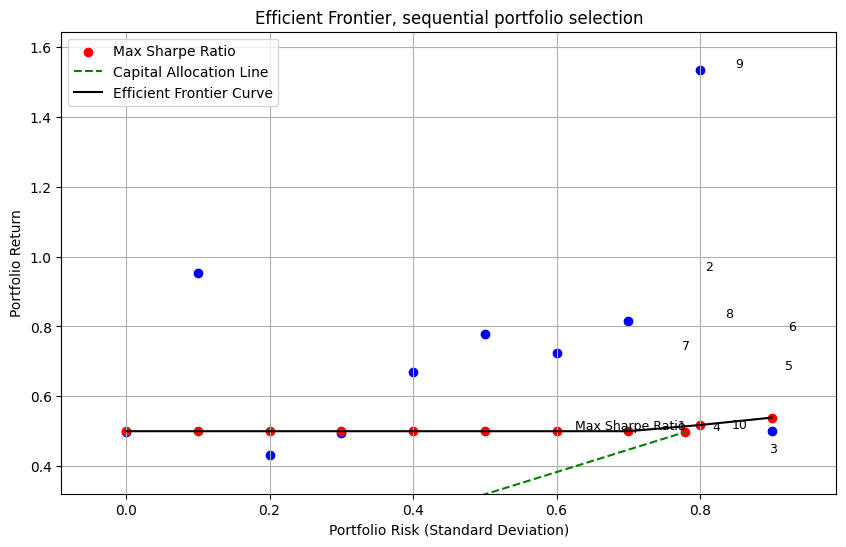

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Next, for each portfolio, calculate the optimal weights using ridge-historical covariance calculation.
# Then, using those weights, calculate the portfolio return and portfolio standard deviation.
# Plot these ten points on the efficient frontier graph.
points = []

# Loop
for ALL_STOCKS in portfolios:
  ALL_STOCK_COUNT = len(ALL_STOCKS)
  TESTING_STOCKS = ALL_STOCKS
  TRAINING_STOCKS = ALL_STOCKS

  WINDOW_SIZE = 502  ## ALL THE DATA
  GO_BACK = 50  ## DATA USED FOR ML


  TRAINING_END_DATE = "2013-12-31"  ## training matrix data from this time period
  TRAINING_START_DATE = date_before_x_days(TRAINING_END_DATE, WINDOW_SIZE)

  TESTING_END_DATE = "2018-12-31"  ## testing matrix data from this time period
  TESTING_START_DATE = date_before_x_days(TESTING_END_DATE, WINDOW_SIZE)


  TRAINING_PREDICTION_DATE = "2018-12-31"
  TESTING_PREDICTION_DATE = "2023-12-31"
  training_data = yf.download(ALL_STOCKS, start=TRAINING_START_DATE, end=TRAINING_END_DATE)
  testing_data = yf.download(ALL_STOCKS, start=TESTING_START_DATE, end=TESTING_END_DATE)
  ALL_STOCKS, training_data, ALL_STOCK_COUNT = clean_data(ALL_STOCKS,
                                                          training_data,
                                                          ALL_STOCK_COUNT)
  ALL_STOCKS, testing_data, ALL_STOCK_COUNT = clean_data(ALL_STOCKS,
                                                          testing_data,
                                                          ALL_STOCK_COUNT)
  ALL_STOCKS, training_data, ALL_STOCK_COUNT = clean_data(ALL_STOCKS,
                                                          training_data,
                                                          ALL_STOCK_COUNT)
  training_X_dict = make_feature_dict(ALL_STOCKS,
                                      training_data,
                                      GO_BACK)

  testing_X_dict = make_feature_dict(ALL_STOCKS,
                                    testing_data,
                                    GO_BACK)
  training_X = dict_to_matrix(training_X_dict)

  testing_X = dict_to_matrix(testing_X_dict)
  n = training_X.shape[1]
  feature_norms = np.zeros(n)

  for i in range(n):
    col = training_X[:, i]
    feature_norms[i] = np.linalg.norm(col)

  training_X = training_X / feature_norms
  testing_X = testing_X / feature_norms
  training_y = obtain_y(TRAINING_PREDICTION_DATE, ALL_STOCKS)
  testing_y = obtain_y(TESTING_PREDICTION_DATE, ALL_STOCKS)

  # Get thetas
  theta = ridge_obtain_thetas(training_X, training_y)

  # Get expected_returns_ridge vector
  proj = testing_X.dot(theta)
  adj = testing_X[:, 1] * feature_norms[1]  ## un-normalizing the matrix
  expected_returns_ridge = (proj - adj) / adj

  # Get historical covariance matrix
  covariance_matrix_historical = calculate_covariance_matrix_hist(TESTING_STOCKS)

  # Get the weights using 0.15 for sigma squared # maybe I should use simple instead...
  weights_complex = calculate_markowitz_weights_complex(0.15, expected_returns_ridge, covariance_matrix_historical)

  # Calculate portfolio return for this portfolio
  portfolio_return = calculate_portfolio_return(weights_complex)
  portfolio_return = portfolio_return * 0.01
  # Calculate portfolio risk = portfolio STANDARD DEVIATION
  portfolio_risk = calculate_portfolio_risk(weights_complex, covariance_matrix_historical)
  print(portfolio_risk)
  points.append([portfolio_risk, portfolio_return])

# Now, plot all of them
risks = [point[0] for point in points]
returns = [point[1] for point in points]

sharpe_ratios = [(r - 0) / s for r, s in zip(returns, risks)]
max_sharpe_index = np.argmax(sharpe_ratios)
max_sharpe_portfolio = points[max_sharpe_index]

# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(risks, returns, color='blue')
plt.scatter(risks_eff, returns_eff, color='red')
plt.title('Efficient Frontier, sequential portfolio selection')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.grid(True)
for i, point in enumerate(points):
    plt.text(point[0], point[1], str(i+1), fontsize=9, verticalalignment='bottom', horizontalalignment='right')

plt.scatter(max_sharpe_portfolio[0], max_sharpe_portfolio[1], color='red', label='Max Sharpe Ratio')
plt.text(max_sharpe_portfolio[0], max_sharpe_portfolio[1], 'Max Sharpe Ratio', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# Plotting the Capital Allocation Line (CAL) from risk-free rate (0) to max Sharpe portfolio
plt.plot([0, max_sharpe_portfolio[0]], [0, max_sharpe_portfolio[1]], color='green', linestyle='--', label='Capital Allocation Line')
x_min, x_max = min(risks), max(risks)
y_min, y_max = min(returns), max(returns)

# Add some padding to the range
x_padding = 0.1 * (x_max - x_min)
y_padding = 0.1 * (y_max - y_min)

# Set the limits of the axes
plt.xlim(x_min - x_padding, x_max + x_padding)
plt.ylim(y_min - y_padding, y_max + y_padding)
plt.legend()
plt.savefig('efficient_frontier_plot_complex1.png', dpi=300)  # Change the file extension to .jpg or .jpeg for JPEG format
plt.show()

In [ ]:
print(points)
print(efficient_portfolios)

[[0.7796336387560243, 0.49808914900652107], [0.8185874077831157, 0.952770010963001], [0.9074023232564029, 0.4314947163121491], [0.827543606981275, 0.49506719787211384], [0.929305769890881, 0.6687014363024971], [0.9339646711861161, 0.7788734898240801], [0.7857765393992611, 0.725304999675906], [0.8461144582985738, 0.817121623934095], [0.860205780647943, 1.5335180881143362], [0.8655927412034146, 0.500212198256494]]
[[0, 0.5002123068834273], [0.1, 0.5002122444847018], [0.2, 0.5002120805931792], [0.3, 0.5002122902773369], [0.4, 0.5002127266998343], [0.5, 0.5002117462037711], [0.6, 0.5002108794759403], [0.7, 0.5002122576658915], [0.8, 0.5179636525747039], [0.9, 0.5391781436155861]]


In [ ]:
# Extra stuff
# MAKING EFFICIENT FRONTIER CURVE (9:17 PM)
efficient_portfolios = []
risks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for risk in risks:
  weights_complex = calculate_markowitz_weights_efficient(risk, expected_returns_ridge, covariance_matrix_historical)
  # Calculate portfolio return for this portfolio
  portfolio_return = calculate_portfolio_return(weights_complex)
  portfolio_return = portfolio_return * 0.01
  ret = [risk, portfolio_return]
  efficient_portfolios.append(ret)

risks_eff = [point[0] for point in efficient_portfolios]
returns_eff = [point[1] for point in efficient_portfolios]
sorted_indices = np.argsort(risks_eff)
sorted_risks = np.array(risks_eff)[sorted_indices]
sorted_returns = np.array(returns_eff)[sorted_indices]

# plot efficient frontier
f = interp1d(sorted_risks, sorted_returns, kind='linear')
x_values = np.linspace(min(sorted_risks), max(sorted_risks), 100)
plt.plot(x_values, f(x_values), color='black', label='Efficient Frontier Curve')